In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.over_sampling import SMOTE
import pandas as pd 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def init_spark():
    spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option", "some-value").getOrCreate()
    return spark
spark_object = init_spark()

23/03/29 19:04:45 WARN Utils: Your hostname, karyubuntu resolves to a loopback address: 127.0.1.1; using 172.31.170.192 instead (on interface wlp0s20f3)
23/03/29 19:04:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/29 19:04:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/29 19:04:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Training data encoding and smote balancing 

In [3]:
train_spark = spark_object.read.option("delimiter", ",").csv("./data/traincleaned.csv", header='true', inferSchema='true')
train_spark = train_spark.drop(col("_c0"))
train_spark = train_spark.drop(col("id_31"))

In [4]:
train_pandas = train_spark.toPandas()

23/03/29 19:05:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
imputer = KNNImputer(n_neighbors=5)

In [6]:
cat_cols = [col for col in train_pandas.columns if train_pandas[col].dtype == 'object']

In [7]:
X_train_temp = pd.get_dummies(train_pandas, columns=cat_cols)
X_train_main = pd.DataFrame(imputer.fit_transform(X_train_temp), columns=X_train_temp.columns)

In [8]:
train, test = train_test_split(X_train_main, test_size=0.3, random_state=42, shuffle=True)

In [9]:
y_train = train['isFraud']
X_train = train.drop('isFraud', axis=1)

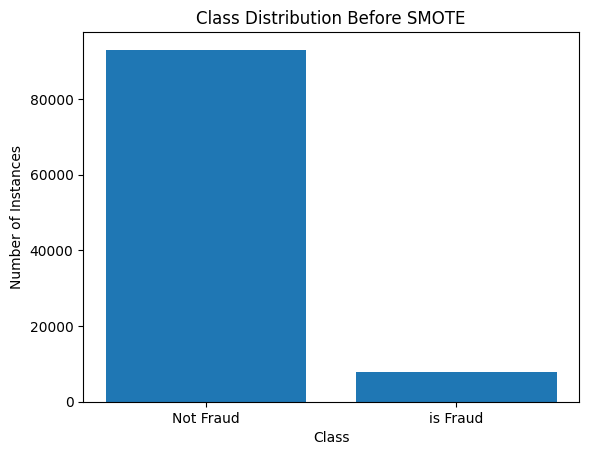

In [10]:
class_counts_before = np.bincount(y_train)

plt.bar(range(len(class_counts_before)), class_counts_before)
plt.xticks(range(len(class_counts_before)), ['Not Fraud', 'is Fraud'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution Before SMOTE')
plt.show()

In [11]:
sm = SMOTE(random_state=42)

In [12]:
X_sm, y_sm = sm.fit_resample(X_train, y_train)


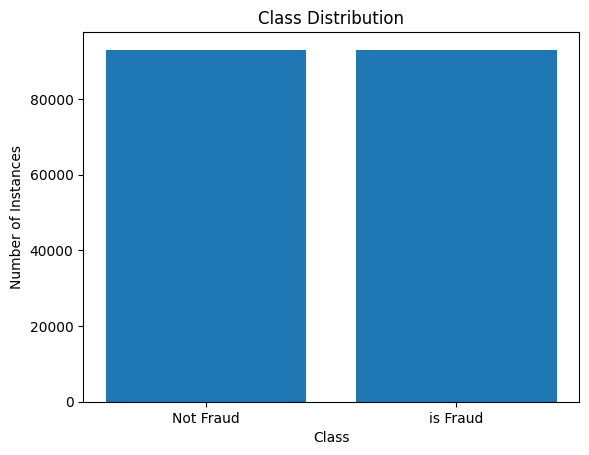

In [13]:
class_counts_after = np.bincount(y_sm)

plt.bar(range(len(class_counts_after)), class_counts_after)
plt.xticks(range(len(class_counts_after)), ['Not Fraud', 'is Fraud'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()


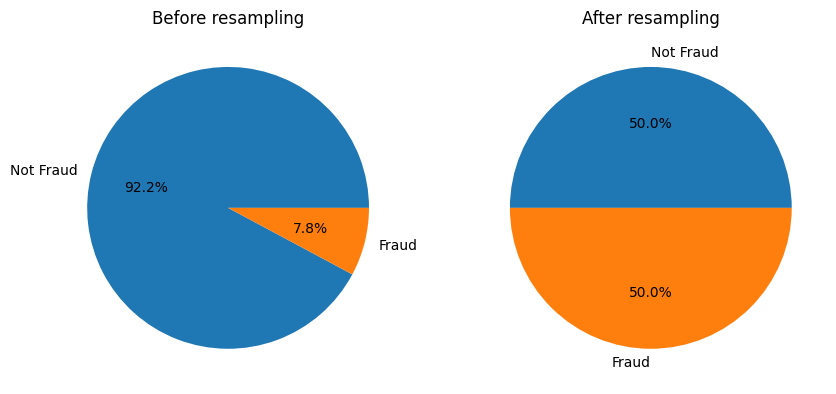

In [14]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

classes=['Not Fraud' ,'Fraud']

# Plot before resampling
ax1.pie(class_counts_before, labels=classes, autopct='%1.1f%%')
ax1.set_title('Before resampling')

# Plot after resampling
ax2.pie(class_counts_after, labels=classes, autopct='%1.1f%%')
ax2.set_title('After resampling')

plt.show()

Stacked Bar Chart


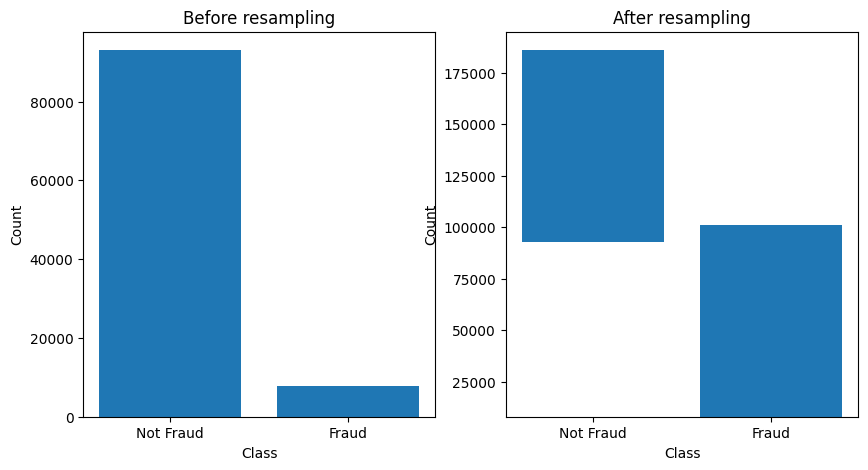

In [15]:
# Plot the data
print('Stacked Bar Chart')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot before resampling
ax1.bar(classes, class_counts_before)
ax1.set_title('Before resampling')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot after resampling
ax2.bar(classes, class_counts_after, bottom=class_counts_before)
ax2.set_title('After resampling')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.show()

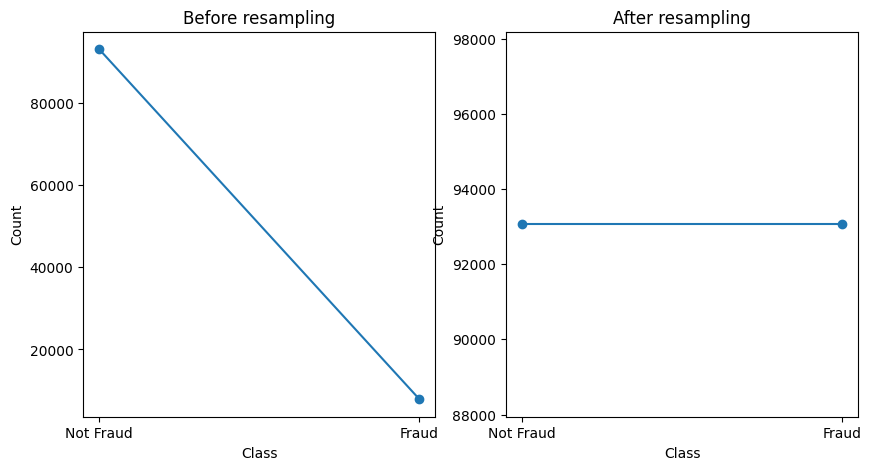

In [16]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot before resampling
ax1.plot(classes, class_counts_before, 'o-')
ax1.set_title('Before resampling')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot after resampling
ax2.plot(classes, class_counts_after, 'o-')
ax2.set_title('After resampling')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.show()

In [21]:
train_balanced_data = pd.concat([X_sm, y_sm], axis=1)

# print((train_balanced_data.count(), len(train_balanced_data.columns)))


In [22]:
train_balanced_data.to_csv('./data/trainbalanced.csv', index=False)

test.to_csv('./data/testbalanced.csv', index=False)